# Bayesian Deep Learning Benchmarks

**Bayesian Deep Learning Benchmarks** (BDL Benchmarks or `bdlb` for short), is an open-source framework that aims to bridge the gap between the design of deep probabilistic machine learning models and their application to real-world problems, hosted on [GitHub](https://github.com/OATML/bdl-benchmarks).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OATML/bdl-benchmarks/blob/alpha/notebooks/diabetic_retinopathy_diagnosis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OATML/bdl-benchmarks/blob/alpha/notebooks/diabetic_retinopathy_diagnosis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [8]:
#@title Dependencies & Prerequisites
!pip3 install --user --quiet --upgrade git+https://github.com/OATML/bdl-benchmarks.git

You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import functools

import numpy as np
import scipy.stats
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import matplotlib.pyplot as plt

if tf.test.gpu_device_name() != "/device:GPU:0":
      raise OSError("GPU device not found")
else:
      print("SUCCESS: Found GPU: {}".format(tf.test.gpu_device_name()))

import bdlb
from bdlb.core.plotting import leaderboard
from bdlb.core.constants import DIABETIC_RETINOPATHY_DIAGNOSIS_URL_MEDIUM
from bdlb.core.constants import LEADERBOARD_DIR_URL

OSError: GPU device not found

In [3]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch.nn.functional as F

from tqdm import tqdm_notebook as tqdm

In [11]:
tf.test.gpu_device_name()

''

## [Diabetic Retinopathy Diagnosis Benchmark](https://github.com/OATML/bdl-benchmarks/tree/alpha/baselines/diabetic_retinopathy_diagnosis)

The benchmark that we use in this example is built on the [Kaggle Diabetic Retinopathy (DR) Detection Challenge data](https://www.kaggle.com/c/diabetic-retinopathy-detection/overview).
It consists of 35,126 training images and 53,576 test images. We hold-out 20% of the training data as a validation set.
Each image is graded by a specialist on the following scale: 0 -- No DR, 1 -- Mild DR, 2 -- Moderate DR, 3 -- Severe DR and 4 -- Proliferative DR.
We recast the 5-class classification task as binary classification which is easily applicable to any BDL classification algorithm by asking the user to classify whether each image has sight-threatening DR, which is defined as Moderate DR or greater (classes 2-4) following [_Leibig et al._](https://www.nature.com/articles/s41598-017-17876-z.pdf).
The data are unbalanced, with  only 19.6% of the training set and 19.2% of the test set having a positive label.

In [5]:
#@title Fetch Data (in TFRecords) & Leaderboard

!pip3 install --quiet --upgrade gdown
!gdown $DIABETIC_RETINOPATHY_DIAGNOSIS_URL_MEDIUM
!mkdir -p data/diabetic_retinopathy_diagnosis
!unzip -qq medium.zip
!mv medium data/diabetic_retinopathy_diagnosis
!rm -rf medium.zip

!gdown $LEADERBOARD_DIR_URL
!unzip -qq leaderboard.zip
!rm -rf leaderboard.zip

Downloading...
From: https://drive.google.com/uc?id=1WAvS-pQsVLxUJiClmKLnVNQkoKmRt2I_
To: /content/medium.zip
685MB [00:11, 59.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LQeAfqMQa4lot09qAuzWa3t6attmCeG-
To: /content/leaderboard.zip
100% 4.64k/4.64k [00:00<00:00, 5.93MB/s]


In [0]:
#@title Hyperparameters { display-mode: "form" }
BATCH_SIZE = 200 #@param {type:"integer"}
NUM_EPOCHS = 10 #@param {type:"slider", min:1, max:100, step:1}
DROPOUT_RATE = 0.1 #@param {type:"slider", min:0, max:1.0, step:0.05}
NUM_MCDROPOUT_SAMPLES = 10 #@param {type:"integer"}

LEVEL = "medium" #@param ["medium"]

input_shape = {"medium": (256, 256, 3),
               "realworld": (512, 512, 3)}[LEVEL]
learning_rate = 1e-3
l2_reg = 5e-5

In [0]:
#@title Helper Functions

def visualize_tfdataset(tfdataset, num_samples):
  """Visualizes `num_samples` from the `tfdataset`."""
  
  def to01(image):
    """Normalizes image to float [0, 1]."""
    min_ = np.min(image)
    max_ = np.max(image)
    return (image - min_) / (max_ - min_)
  
  for X, y in tfdataset.take(1):
    images = X.numpy()
    labels = y.numpy()
    B, _, _, _ = images.shape
    num_samples = min(num_samples, B)
    fig, axes = plt.subplots(figsize=(2.0*num_samples, 2.0), ncols=num_samples)
    for i in range(num_samples):
      ax = axes[i]
      ax.imshow(to01(images[i]))
      ax.axis("off")
      ax.set(title="healthy" if labels[i] == 0 else "diseased")
    fig.show()

### Benchmark API

The benchmarks can be easily loaded using `bdlb.load(benchmark, level, data_dir, batch_size)`.
All the data management (i.e. download, prepare, preprocess, load, batch and prefetch) is abstracted away from the user and is **compatible with any deep learning framework**!

In [0]:
dtask = bdlb.load(
    benchmark="diabetic_retinopathy_diagnosis",
    level=LEVEL,
    batch_size=BATCH_SIZE,
    data_dir="data",
    download_and_prepare=False,
)
train_ds, validation_ds, test_ds = dtask.datasets

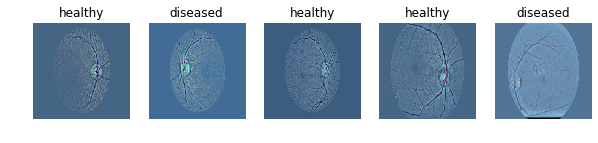

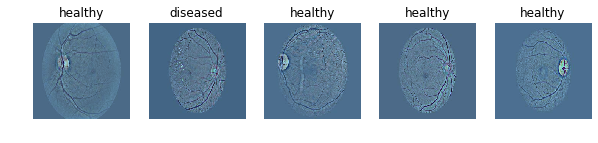

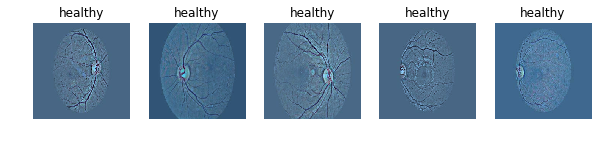

In [12]:
#@title Visualize Data
visualize_tfdataset(ds_train, num_samples=5)
visualize_tfdataset(ds_validation, num_samples=5)
visualize_tfdataset(ds_test, num_samples=5)

In [72]:
from sklearn.utils.class_weight import compute_class_weight

from numpy.random import binomial

y = binomial(1,0.195,1000)

compute_class_weight('balanced', np.unique(y), y)

array([0.61957869, 2.59067358])

In [0]:
def train_from_tf(model, train_ds, test_ds, batch_size, epochs):   
    
  """
  train model on train_loader dataset (with parameters batch_size and epochs) and display
  the accuracy on test_loader dataset after each epoch
  """

  optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

  class_weights = torch.FloatTensor([1,7]).cuda()
  criterion = nn.CrossEntropyLoss(weight=class_weights)

  num_batch = int(35e3/batch_size)
  
  for e in range(epochs):    
    for img, lbl in train_ds.take(num_batch):
      x = torch.from_numpy(img.numpy()).float().transpose(1,3).transpose(2,3)
      y = torch.from_numpy(lbl.numpy()).long()
      optimizer.zero_grad()
      x, y = to_var(x), to_var(y)
      out = model(x,False)
      loss = criterion(out, y)
      loss.backward()
      optimizer.step()

    print('\tat epoch {} of the training the f1 score on test set is {}'.format(e+1,test_f1_score_from_tf(model, test_ds, batch_size)))
        
def test_f1_score_from_tf(model, test_ds, batch_size):
    
    """
    return the accuracy of the model on the test dataset
    """
    
    from sklearn.metrics import f1_score
    
    nb_errors = 0
    num_batch = int(10e3/batch_size)
    
    y_pred = np.array([])
    y_true = np.array([])
    
    for img, lbl in test_ds.take(num_batch):
      x = torch.from_numpy(img.numpy()).float().transpose(1,3).transpose(2,3)
      y = torch.from_numpy(lbl.numpy()).long()
      x, y = to_var(x), to_var(y)
      out = model(x,False)
      _, y_hat = out.data.max(1)
      
      y_true = np.concatenate((y_true, y.cpu().numpy()))
      y_pred = np.concatenate((y_pred, y_hat.cpu().numpy()))                          
            
    return f1_score(y_true,y_pred)

In [47]:
for img, lbl in train_ds.take(5):
  y = lbl.numpy()
  print('class 0 : {}, class 1 : {}'.format(y[(y==0)].shape[0]/y.shape[0],y[(y==1)].shape[0]/y.shape[0]))

class 0 : 0.8125, class 1 : 0.1875
class 0 : 0.75, class 1 : 0.25
class 0 : 0.8125, class 1 : 0.1875
class 0 : 0.8359375, class 1 : 0.1640625
class 0 : 0.8046875, class 1 : 0.1953125


In [79]:
model = VGG_MC()
epochs = 50
batch_size = 200

if torch.cuda.is_available():
    model.cuda()
    
print('model {} contains {} parameters'.format(model.get_name(), model.count_parameters()))
print('\tat epoch 0 of the training the f1 score on test set is {}'.format(test_f1_score_from_tf(model, test_ds, batch_size)))
train_from_tf(model, train_ds, test_ds, batch_size, epochs)

model VGG_MC contains 2657858 parameters
	at epoch 0 of the training the f1 score on test set is 0.3219716832721552
	at epoch 1 of the training the f1 score on test set is 0.32219163717394156
	at epoch 2 of the training the f1 score on test set is 0.32219163717394156
	at epoch 3 of the training the f1 score on test set is 0.32219163717394156
	at epoch 4 of the training the f1 score on test set is 0.32219163717394156
	at epoch 5 of the training the f1 score on test set is 0.32219163717394156
	at epoch 6 of the training the f1 score on test set is 0.32219163717394156
	at epoch 7 of the training the f1 score on test set is 0.3224115334207078
	at epoch 8 of the training the f1 score on test set is 0.32175167169267077
	at epoch 9 of the training the f1 score on test set is 0.32263137203511993
	at epoch 10 of the training the f1 score on test set is 0.3224115334207078
	at epoch 11 of the training the f1 score on test set is 0.3240312128025393
	at epoch 12 of the training the f1 score on test

FileNotFoundError: ignored

In [0]:
torch.save(model.state_dict(), F"/content/drive/My Drive/models/{model.get_name()}_pretrain{str(epochs)}.pkl")

In [0]:
def prune_network(model, train_ds, test_ds, batch_size, epochs, mode = ['weights','local']):
    
    """
    prune the network with various pruning rates from 0% to 100%
    pruning can be made by weights/filters and global/local, default is localy per weights
    
    """
        
    pruning = np.linspace(0,95,20)

    for p in pruning:
        if os.path.isfile("drive/My Drive/models/{}_pretrain{}_pr{}.pkl".format(model.get_name(),epochs,int(p))):
            continue
        if p == 0:
            # Load the pretrained model
            model.load_state_dict(torch.load("drive/My Drive/models/{}_pretrain{}.pkl".format(model.get_name(),epochs)))
        else:
            model.load_state_dict(torch.load("drive/My Drive/models/{}_pretrain{}_pr{}.pkl".format(model.get_name(),epochs,int(p-5))))

        # prune the weights
        masks = weight_prune(model, p, mode[1])
        model.set_masks(masks, mode[0])

        # Retraining
        train_from_tf(model, train_ds, test_ds, batch_size, 10)

        # Save the entire model on Google Drive
        torch.save(model.state_dict(), "drive/My Drive/models/{}_pretrain{}_pr{}.pkl".format(model.get_name(),epochs,int(p)))
        
def weight_prune(model, pr, mode): 
    
    """
    return a mask to prune weights whose absolute value is below a treshold computed to reach
    the given pruning rate (pr)
    """
    
    masks = []
    
    if mode == 'local':
        for name, p in model.named_parameters():
            thresh = np.percentile(p.cpu().data.abs().numpy().flatten(), pr)
            if 'weight' in name:
                if len(p.data.size()) != 1:
                    pruned_inds = p.data.abs() > thresh
                    masks.append(pruned_inds.float())
                    
    if mode == 'global':
        all_weights = []
        for p in model.parameters():
            if len(p.data.size()) != 1:
                all_weights += list(p.cpu().data.abs().numpy().flatten())
        thresh = np.percentile(np.array(all_weights), pr)

        for name, p in model.named_parameters():
            if 'weight' in name:
                if len(p.data.size()) != 1:
                    pruned_inds = p.data.abs() > thresh
                    masks.append(pruned_inds.float())
    
    return masks

In [86]:
mode = ['weights','local']

prune_network(model, train_ds, test_ds, batch_size, epochs, mode)

	at epoch 1 of the training the f1 score on test set is 0.4139065069297628
	at epoch 2 of the training the f1 score on test set is 0.43916242218449353
	at epoch 3 of the training the f1 score on test set is 0.43690409422321924
	at epoch 4 of the training the f1 score on test set is 0.41851676901275386
	at epoch 5 of the training the f1 score on test set is 0.42824014429270807
	at epoch 6 of the training the f1 score on test set is 0.4179807013414922
	at epoch 7 of the training the f1 score on test set is 0.42228598756575797
	at epoch 8 of the training the f1 score on test set is 0.40143369175627236
	at epoch 9 of the training the f1 score on test set is 0.4395296752519597
	at epoch 10 of the training the f1 score on test set is 0.40913043478260863
	at epoch 1 of the training the f1 score on test set is 0.41167501633631015
	at epoch 2 of the training the f1 score on test set is 0.41754225673823664
	at epoch 3 of the training the f1 score on test set is 0.40812797233030695
	at epoch 4 of

In [33]:
model = VGG_MC()
epochs = 100
batch_size = 200

if torch.cuda.is_available():
    model.cuda()
    
print('model {} contains {} parameters'.format(model.get_name(), model.count_parameters()))

for e in [99-i for i in range(epochs)]:
  if os.path.isfile("drive/My Drive/models/{}_pretrain{}.pkl".format(model.get_name(),e)):
    model.load_state_dict(torch.load("drive/My Drive/models/{}_pretrain{}.pkl".format(model.get_name(),e)))
    print("LOADING drive/My Drive/models/{}_pretrain{}.pkl".format(model.get_name(),e))
    e_load = e
    continue

print('\tat epoch e of the training the f1 score on test set is {}'.format(test_f1_score_from_tf(model, test_ds, batch_size)))
train_from_tf(model, train_ds, test_ds, batch_size, epochs-e_load)
torch.save(model.state_dict(), F"drive/My Drive/models/{model.get_name()}_pretrain{str(epochs)}.pkl")

model VGG_MC contains 2657858 parameters
LOADING drive/My Drive/models/VGG_MC_pretrain50.pkl


RuntimeError: ignored

### Network pretraining

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [0]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [0]:
def to_var(x, requires_grad=False):
    
    """
    return the input in Variable format after having applied cuda transformation if possible
    """
    
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [0]:
class VGG_MC(nn.Module):
    def __init__(self):
        super(VGG_MC, self).__init__()
        # Block 1
        self.conv1 = MaskedConv2d(3, 32, kernel_size=3, padding=1, stride=2) # padding = 'same'
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 2
        self.conv2 = MaskedConv2d(32, 32, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = MaskedConv2d(32, 32, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 3
        self.conv4 = MaskedConv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = MaskedConv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 4
        self.conv6 = MaskedConv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.relu6 = nn.ReLU(inplace=True)
        self.conv7 = MaskedConv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.conv8 = MaskedConv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.relu8 = nn.ReLU(inplace=True)
        self.conv9 = MaskedConv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.relu9 = nn.ReLU(inplace=True)
        self.maxpool9 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Block 5
        self.conv10 = MaskedConv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.relu10 = nn.ReLU(inplace=True)
        self.conv11 = MaskedConv2d(256, 256, kernel_size=3, padding=1, stride=1)
        self.relu11 = nn.ReLU(inplace=True)
        self.conv12 = MaskedConv2d(256, 256, kernel_size=3, padding=1, stride=1)
        self.relu12 = nn.ReLU(inplace=True)
        self.conv13 = MaskedConv2d(256, 256, kernel_size=3, padding=1, stride=1)
        self.relu13 = nn.ReLU(inplace=True)
        
        # Global poolings
        self.maxpool14 = nn.MaxPool2d(kernel_size=256)
        self.avgpool14 = nn.AvgPool2d(kernel_size=256)
        
        # Fully connected
        self.linear14 = MaskedLinear(512,2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        x = self.maxpool1(F.dropout(self.relu1(self.conv1(x)),0.1, training=training))
        
        x = F.dropout(self.relu2(self.conv2(x)),0.1, training=training)
        x = self.maxpool3(F.dropout(self.relu3(self.conv3(x)),0.1, training=training))
        
        x = F.dropout(self.relu4(self.conv4(x)),0.1, training=training)
        x = self.maxpool5(F.dropout(self.relu5(self.conv5(x)),0.1, training=training))
        
        x = F.dropout(self.relu6(self.conv6(x)),0.1, training=training)
        x = F.dropout(self.relu7(self.conv7(x)),0.1, training=training)
        x = F.dropout(self.relu8(self.conv8(x)),0.1, training=training)
        x = self.maxpool9(F.dropout(self.relu9(self.conv9(x)),0.1, training=training))
        
        x = F.dropout(self.relu10(self.conv10(x)),0.1, training=training)
        x = F.dropout(self.relu11(self.conv11(x)),0.1, training=training)
        x = F.dropout(self.relu12(self.conv12(x)),0.1, training=training)
        x = F.dropout(self.relu13(self.conv13(x)),0.1, training=training)
        x = torch.cat((self.maxpool14(x).view(-1,256),self.avgpool14(x).view(-1,256)),dim=1)
        
        x = self.softmax(self.linear14(x))
        return x

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'filters':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
            self.conv3.set_mask(masks[2])
            self.conv4.set_mask(masks[3])
            self.conv5.set_mask(masks[4])
            self.conv6.set_mask(masks[5])
            self.conv7.set_mask(masks[6])
            self.conv8.set_mask(masks[7])
            self.conv9.set_mask(masks[8])
            self.conv10.set_mask(masks[9])
            self.conv11.set_mask(masks[10])
            self.conv12.set_mask(masks[11])
            self.conv13.set_mask(masks[12])
        if mode == 'weights':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
            self.conv3.set_mask(masks[2])
            self.conv4.set_mask(masks[3])
            self.conv5.set_mask(masks[4])
            self.conv6.set_mask(masks[5])
            self.conv7.set_mask(masks[6])
            self.conv8.set_mask(masks[7])
            self.conv9.set_mask(masks[8])
            self.conv10.set_mask(masks[9])
            self.conv11.set_mask(masks[10])
            self.conv12.set_mask(masks[11])
            self.conv13.set_mask(masks[12])
            self.linear14.set_mask(masks[13])
            
    def get_name(self):
        return 'VGG_MC'
      
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Evaluate Model

Machine learning researchers often evaluate their predictions directly on the whole test set.
But, in fact, in real-world settings we have additional choices available, like asking for more information when we are uncertain.
Because of the importance of accurate diagnosis, it would be unreasonable _not_ to ask for further scans of the most ambiguous cases.
Moreover, in this dataset, many images feature camera artefacts that distort results.
In these cases, it is critically important that a model is able to tell when the information provided to it is not sufficiently reliable to classify the patient.
Just like real medical professionals, any diagnostic algorithm should be able to flag cases that require more investigation by medical experts.

<p align="center">
<img src="http://www.cs.ox.ac.uk/people/angelos.filos/assets/bdl-benchmarks/diagnosis.png" >
</p>

This task is illustrated in the figure above, where a threshold, τ, is used to flag cases as certain and uncertain, with uncertain cases referred to an expert. Alternatively, the uncertainty estimates could be used to come up with a priority list, which could be matched to the available resources of a hospital, rather than waste diagnostic resources on patients for whom the diagnosis is clear cut.

In order to simulate this process of referring the uncertain cases to experts and relying on the model's predictions for cases it is certain of, we assess the techniques by their diagnostic accuracy and area under receiver-operating-characteristic (ROC) curve, as a function of the
referral rate. We expect the models with well-calibrated uncertainty to refer their least confident predictions to experts,
improving their performance as the number of referrals increases.

The accuracy of the binary classifier is defined as the ratio of correctly classified data-points over the size of the population.
The receiver-operating-characteristic (ROC) curve illustrates
the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
It is created by plotting the true positive rate (a.k.a. sensitivity) against the false positive rate (a.k.a. 1 - sensitivity).
The quality of such a ROC curve can be summarized by its area under the curve (AUC), which varies between 0.5 (chance level) and 1.0 (best possible value).